The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
dataset=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00374/energydata_complete.csv')

#### Attribute Information:

date time year-month-day hour:minute:second

Appliances, energy use in Wh

lights, energy use of light fixtures in the house in Wh

T1, Temperature in kitchen area, in Celsius

RH_1, Humidity in kitchen area, in %

T2, Temperature in living room area, in Celsius

RH_2, Humidity in living room area, in %

T3, Temperature in laundry room area

RH_3, Humidity in laundry room area, in %

T4, Temperature in office room, in Celsius

RH_4, Humidity in office room, in %

T5, Temperature in bathroom, in Celsius

RH_5, Humidity in bathroom, in %

T6, Temperature outside the building (north side), in Celsius

RH_6, Humidity outside the building (north side), in %

T7, Temperature in ironing room , in Celsius

RH_7, Humidity in ironing room, in %

T8, Temperature in teenager room 2, in Celsius

RH_8, Humidity in teenager room 2, in %

T9, Temperature in parents room, in Celsius

RH_9, Humidity in parents room, in %

To, Temperature outside (from Chievres weather station), in Celsius

Pressure (from Chievres weather station), in mm Hg

RH_out, Humidity outside (from Chievres weather station), in %

Wind speed (from Chievres weather station), in m/s

Visibility (from Chievres weather station), in km

Tdewpoint (from Chievres weather station), Â°C

rv1, Random variable 1, nondimensional

rv2, Random variable 2, nondimensional


In [3]:
dataset.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

In [4]:
dataset.shape

(19735, 29)

In [5]:
dataset.dtypes

date            object
Appliances       int64
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
dtype: object

##### Feature Engineering

In [6]:
#Converting date to datetime format
dataset['date'] = pd.to_datetime(dataset['date'].str.strip(), format='%Y-%m-%d %H:%M:%S')

In [7]:
# As we have to predict Appliance power consumption, based on IOT sensors data, along with other ambient parameters
#Let's break date to day, weekday/weekend of week as a sepetate feature
import datetime as dt
days = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
dataset['day_of_week'] = dataset['date'].dt.dayofweek
dataset['day_of_week']=dataset['day_of_week'].apply(lambda x: days[x])
dataset['week_day'] = np.where(((dataset['date']).dt.dayofweek) < 5,"weekday","weekend")

In [8]:
# As Wh is calculated as amount of energy consumed in a time period
#Let's add a feature hr_sec to get a more realistic predictor  
dataset['day_hour'] = dataset['date'].dt.hour
dataset['day_min'] = dataset['date'].dt.minute
dataset['hr_sec']=dataset['day_hour']*60*60+dataset['day_min']

In [9]:
dataset.head(2)

date  Appliances  lights     T1       RH_1    T2     RH_2  \
0 2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.7900   
1 2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.7225   

      T3   RH_3    T4  ...  Windspeed  Visibility  Tdewpoint        rv1  \
0  19.79  44.73  19.0  ...   7.000000   63.000000        5.3  13.275433   
1  19.79  44.79  19.0  ...   6.666667   59.166667        5.2  18.606195   

         rv2  day_of_week  week_day  day_hour  day_min  hr_sec  
0  13.275433          Mon   weekday        17        0   61200  
1  18.606195          Mon   weekday        17       10   61210  

[2 rows x 34 columns]

In [10]:
# Dropping date, hour, minute column from dataframe as these features have been separately claimed as a new feature
dataset.drop(['date', 'day_hour','day_min'], axis = 1, inplace = True)

In [11]:
dataset.head(3)

Appliances  lights     T1       RH_1    T2       RH_2     T3       RH_3  \
0          60      30  19.89  47.596667  19.2  44.790000  19.79  44.730000   
1          60      30  19.89  46.693333  19.2  44.722500  19.79  44.790000   
2          50      30  19.89  46.300000  19.2  44.626667  19.79  44.933333   

          T4       RH_4  ...  Press_mm_hg  RH_out  Windspeed  Visibility  \
0  19.000000  45.566667  ...        733.5    92.0   7.000000   63.000000   
1  19.000000  45.992500  ...        733.6    92.0   6.666667   59.166667   
2  18.926667  45.890000  ...        733.7    92.0   6.333333   55.333333   

   Tdewpoint        rv1        rv2  day_of_week  week_day  hr_sec  
0        5.3  13.275433  13.275433          Mon   weekday   61200  
1        5.2  18.606195  18.606195          Mon   weekday   61210  
2        5.1  28.642668  28.642668          Mon   weekday   61220  

[3 rows x 31 columns]

In [12]:
dataset.describe()

Appliances        lights            T1          RH_1            T2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875     21.686571     40.259739     20.341219   
std      102.524891      7.935988      1.606066      3.979299      2.192974   
min       10.000000      0.000000     16.790000     27.023333     16.100000   
25%       50.000000      0.000000     20.760000     37.333333     18.790000   
50%       60.000000      0.000000     21.600000     39.656667     20.000000   
75%      100.000000      0.000000     22.600000     43.066667     21.500000   
max     1080.000000     70.000000     26.260000     63.360000     29.856667   

               RH_2            T3          RH_3            T4          RH_4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.420420     22.267611     39.242500     20.855335     39.026904   
std        4.069813      2.006111      3.254576      2.042884      4.341321   
min       20.463333     17.200000     28.766667     15.100000     27.660000   
25%       37.900000     20.790000     36.900000     19.530000     35.530000   
50%       40.500000     22.100000     38.530000     20.666667     38.400000   
75%       43.260000     23.290000     41.760000     22.100000     42.156667   
max       56.026667     29.236000     50.163333     26.200000     51.090000   

       ...          RH_9         T_out   Press_mm_hg        RH_out  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...     41.552401      7.411665    755.522602     79.750418   
std    ...      4.151497      5.317409      7.399441     14.901088   
min    ...     29.166667     -5.000000    729.300000     24.000000   
25%    ...     38.500000      3.666667    750.933333     70.333333   
50%    ...     40.900000      6.916667    756.100000     83.666667   
75%    ...     44.338095     10.408333    760.933333     91.666667   
max    ...     53.326667     26.100000    772.300000    100.000000   

          Windspeed    Visibility     Tdewpoint           rv1           rv2  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean       4.039752     38.330834      3.760707     24.988033     24.988033   
std        2.451221     11.794719      4.194648     14.496634     14.496634   
min        0.000000      1.000000     -6.600000      0.005322      0.005322   
25%        2.000000     29.000000      0.900000     12.497889     12.497889   
50%        3.666667     40.000000      3.433333     24.897653     24.897653   
75%        5.500000     40.000000      6.566667     37.583769     37.583769   
max       14.000000     66.000000     15.500000     49.996530     49.996530   

             hr_sec  
count  19735.000000  
mean   41432.204206  
std    24919.035167  
min        0.000000  
25%    21600.000000  
50%    43200.000000  
75%    61250.000000  
max    82850.000000  

[8 rows x 29 columns]

In [13]:
dataset.isnull().sum()

Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
day_of_week    0
week_day       0
hr_sec         0
dtype: int64

##### Segregating similar columns together for better analysis

In [14]:
col_date = ["day_of_week","week_day","hr_sec"]
col_temp = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]
col_hum = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]
col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg","Windspeed","Visibility"] 
col_light = ["lights"]
col_randoms = ["rv1", "rv2"]
col_target = ["Appliances"]
col_hr_sec = ["hr_sec"]

In [15]:
dataset.shape

(19735, 31)

##### Rearanging dataframe columns

In [16]:
dataset=dataset[col_date + col_temp + col_hum + col_weather + col_light + col_target]

In [17]:
dataset.head(2)

day_of_week week_day  hr_sec     T1    T2     T3    T4         T5        T6  \
0         Mon  weekday   61200  19.89  19.2  19.79  19.0  17.166667  7.026667   
1         Mon  weekday   61210  19.89  19.2  19.79  19.0  17.166667  6.833333   

     T7  ...       RH_8   RH_9     T_out  Tdewpoint  RH_out  Press_mm_hg  \
0  17.2  ...  48.900000  45.53  6.600000        5.3    92.0        733.5   
1  17.2  ...  48.863333  45.56  6.483333        5.2    92.0        733.6   

   Windspeed  Visibility  lights  Appliances  
0   7.000000   63.000000      30          60  
1   6.666667   59.166667      30          60  

[2 rows x 29 columns]

In [18]:
dataset.skew()

hr_sec        -0.000673
T1             0.120917
T2             0.889658
T3             0.450777
T4             0.170384
T5             0.558220
T6             0.597471
T7             0.254722
T8            -0.256151
T9             0.382711
RH_1           0.465774
RH_2          -0.268247
RH_3           0.467589
RH_4           0.444614
RH_5           1.866820
RH_6          -0.241961
RH_7           0.242141
RH_8           0.308036
RH_9           0.368937
T_out          0.534273
Tdewpoint      0.239374
RH_out        -0.922997
Press_mm_hg   -0.420442
Windspeed      0.859982
Visibility     0.441554
lights         2.195155
Appliances     3.386367
dtype: float64

In [19]:
dataset.describe()

hr_sec            T1            T2            T3            T4  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean   41432.204206     21.686571     20.341219     22.267611     20.855335   
std    24919.035167      1.606066      2.192974      2.006111      2.042884   
min        0.000000     16.790000     16.100000     17.200000     15.100000   
25%    21600.000000     20.760000     18.790000     20.790000     19.530000   
50%    43200.000000     21.600000     20.000000     22.100000     20.666667   
75%    61250.000000     22.600000     21.500000     23.290000     22.100000   
max    82850.000000     26.260000     29.856667     29.236000     26.200000   

                 T5            T6            T7            T8            T9  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      19.592106      7.910939     20.267106     22.029107     19.485828   
std        1.844623      6.090347      2.109993      1.956162      2.014712   
min       15.330000     -6.065000     15.390000     16.306667     14.890000   
25%       18.277500      3.626667     18.700000     20.790000     18.000000   
50%       19.390000      7.300000     20.033333     22.100000     19.390000   
75%       20.619643     11.256000     21.600000     23.390000     20.600000   
max       25.795000     28.290000     26.000000     27.230000     24.500000   

       ...          RH_8          RH_9         T_out     Tdewpoint  \
count  ...  19735.000000  19735.000000  19735.000000  19735.000000   
mean   ...     42.936165     41.552401      7.411665      3.760707   
std    ...      5.224361      4.151497      5.317409      4.194648   
min    ...     29.600000     29.166667     -5.000000     -6.600000   
25%    ...     39.066667     38.500000      3.666667      0.900000   
50%    ...     42.375000     40.900000      6.916667      3.433333   
75%    ...     46.536000     44.338095     10.408333      6.566667   
max    ...     58.780000     53.326667     26.100000     15.500000   

             RH_out   Press_mm_hg     Windspeed    Visibility        lights  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      79.750418    755.522602      4.039752     38.330834      3.801875   
std       14.901088      7.399441      2.451221     11.794719      7.935988   
min       24.000000    729.300000      0.000000      1.000000      0.000000   
25%       70.333333    750.933333      2.000000     29.000000      0.000000   
50%       83.666667    756.100000      3.666667     40.000000      0.000000   
75%       91.666667    760.933333      5.500000     40.000000      0.000000   
max      100.000000    772.300000     14.000000     66.000000     70.000000   

         Appliances  
count  19735.000000  
mean      97.694958  
std      102.524891  
min       10.000000  
25%       50.000000  
50%       60.000000  
75%      100.000000  
max     1080.000000  

[8 rows x 27 columns]

RH_5 - This column is positively skewed

Light - This column is postively skewed

Appliance -  This column is positively skewed

##### Univariate Analysis

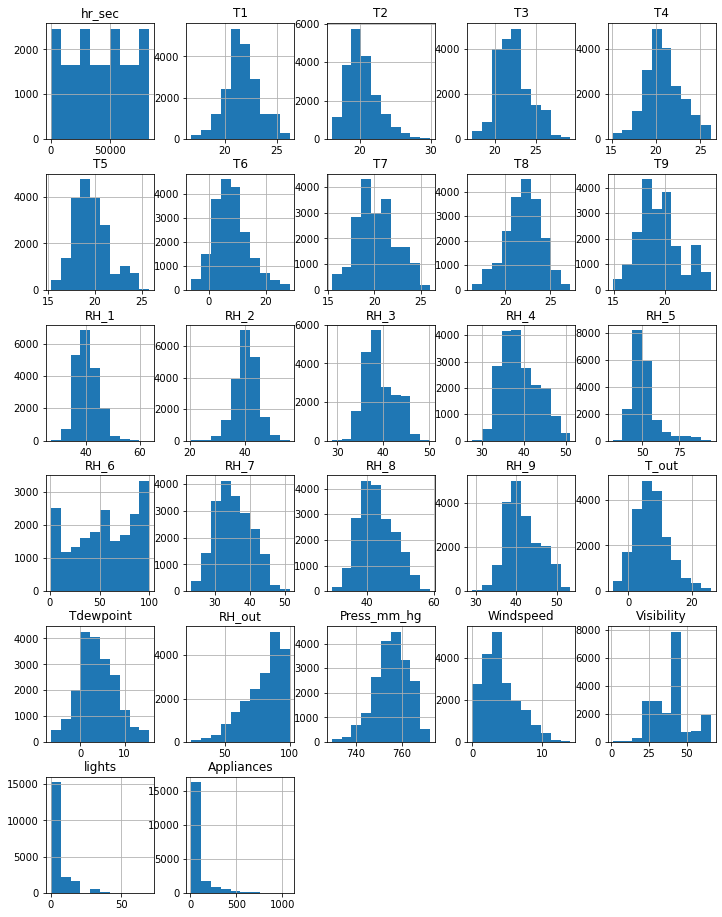

In [20]:
#Histogram of individual features of dataset
%matplotlib inline
_=dataset.hist(figsize= (12,16))

##### The distribution of many features are not normal

#### Lets explore the relation between the dependent variable and independent variables

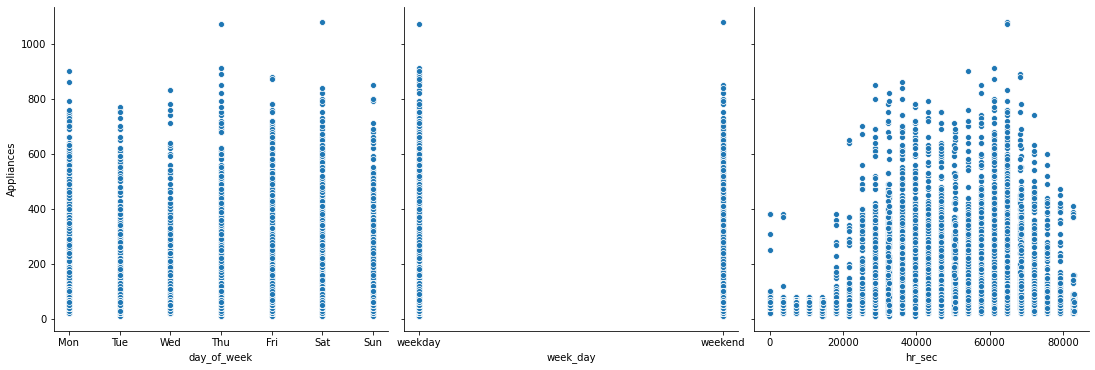

In [21]:
pair_plot = sns.pairplot(data=dataset,
                  y_vars=['Appliances'],
                  x_vars=['day_of_week','week_day','hr_sec'],size=5)

Energy consumption varies with weekdays and hr_sec

However week_day doesn't have much significant impact on energy consumption

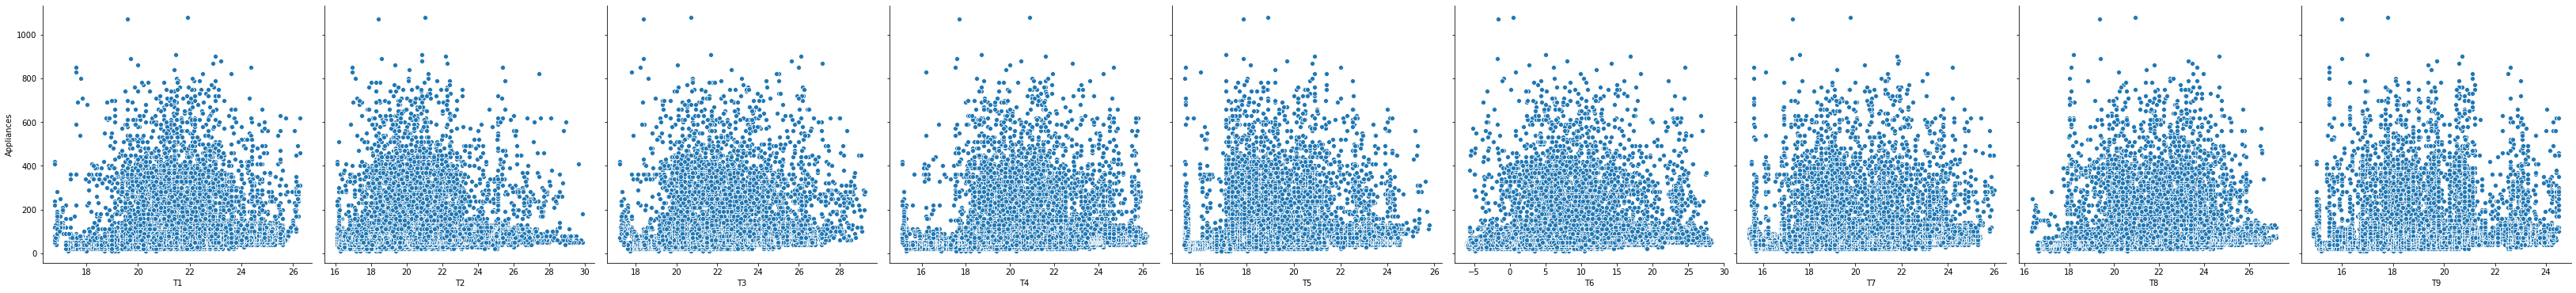

In [22]:
pair_plot = sns.pairplot(data=dataset,
                  y_vars=['Appliances'],
                  x_vars=['T1','T2','T3','T4','T5','T6','T7','T8','T9'],size=5)

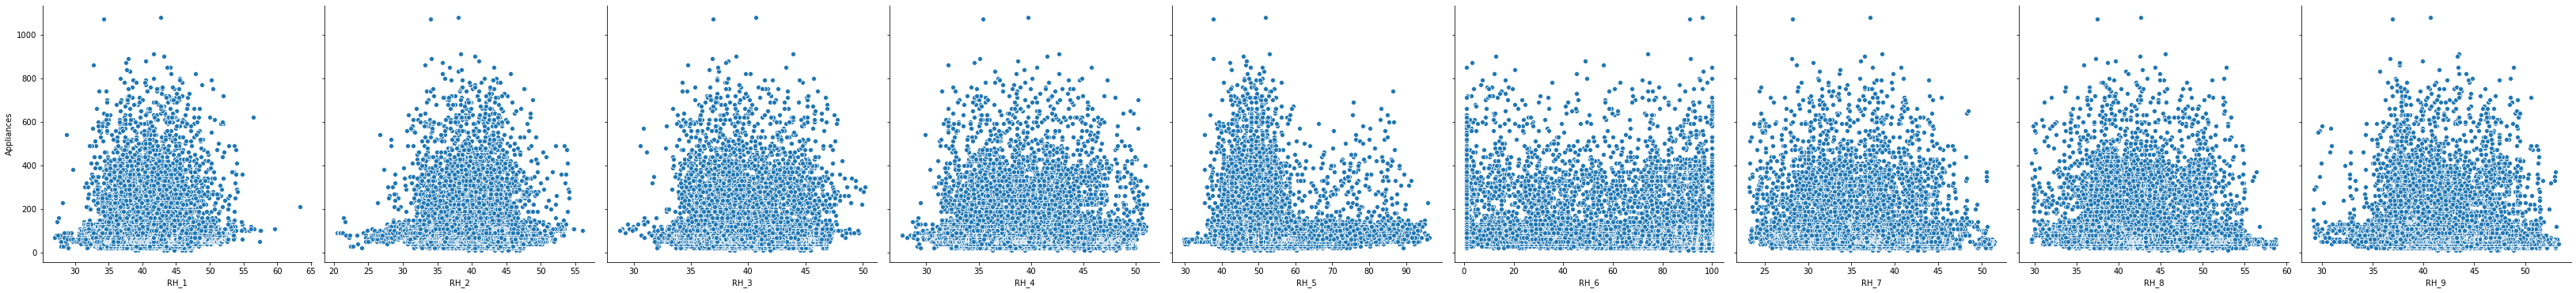

In [23]:
pair_plot = sns.pairplot(data=dataset,
                  y_vars=['Appliances'],
                  x_vars=['RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9'],size=5)

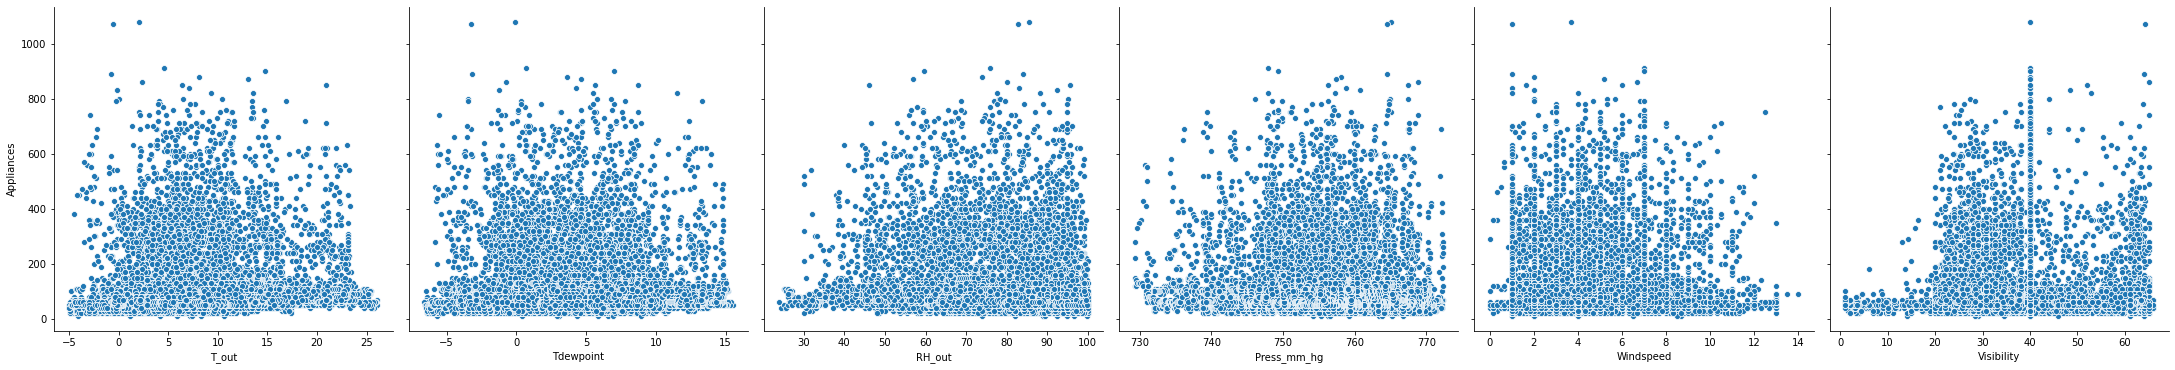

In [24]:
pair_plot = sns.pairplot(data=dataset,
                  y_vars=['Appliances'],
                  x_vars=['T_out','Tdewpoint','RH_out','Press_mm_hg','Windspeed','Visibility'],size=5)


It seems that the dependent variable Appliances, have relation between most of the independent variable, with some features the relation seems to be linear, but in many cases the relation is non linear.

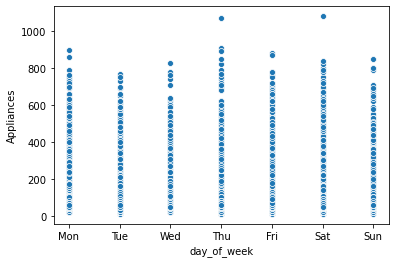

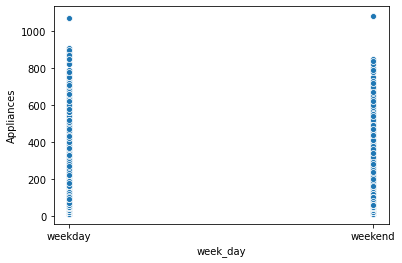

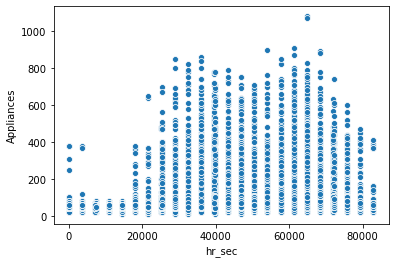

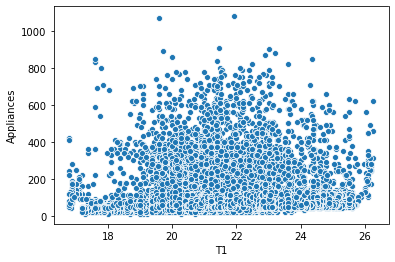

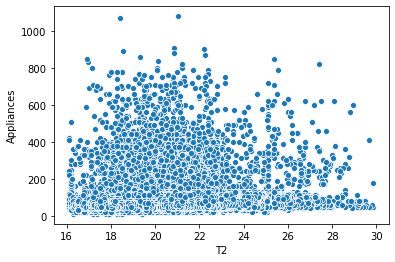

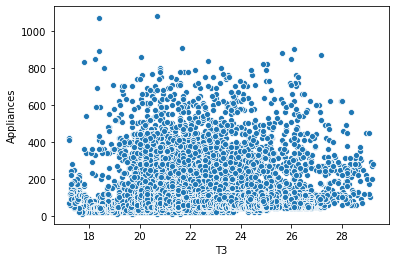

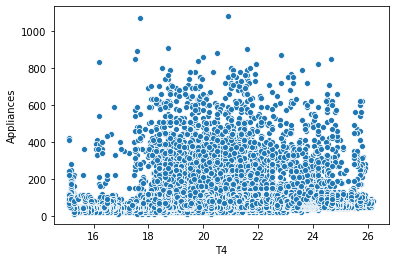

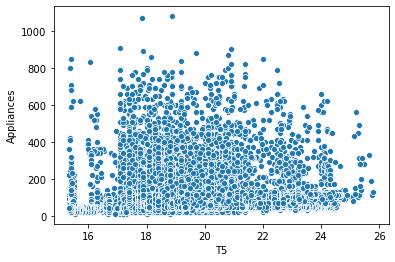

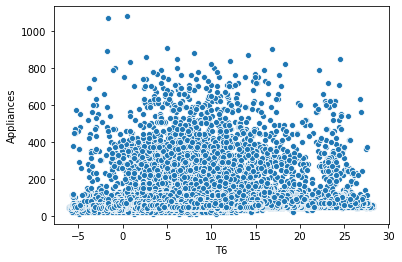

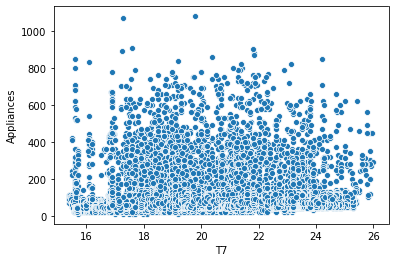

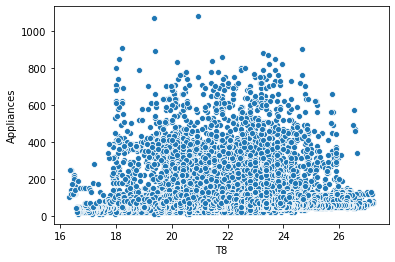

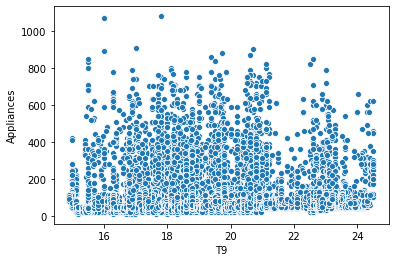

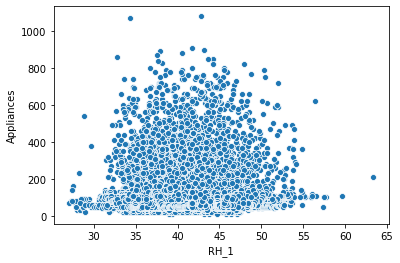

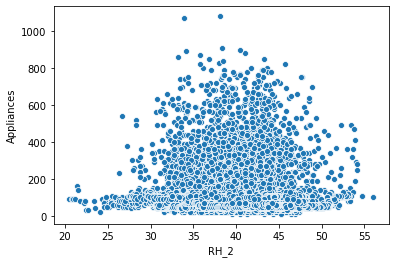

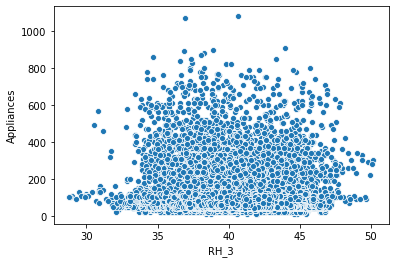

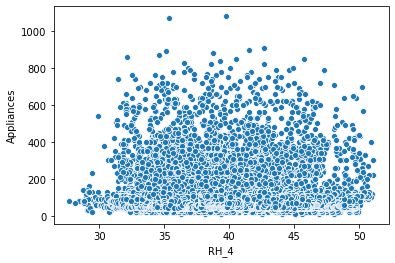

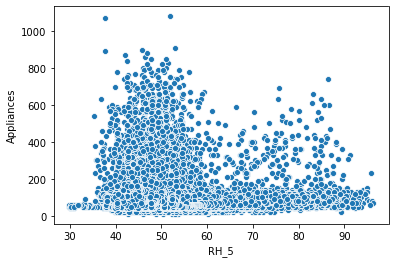

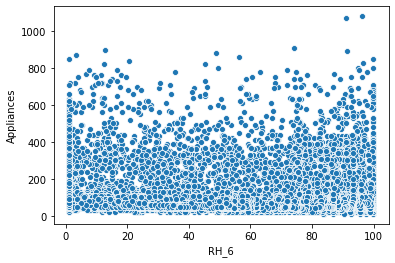

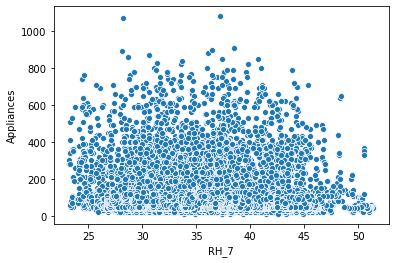

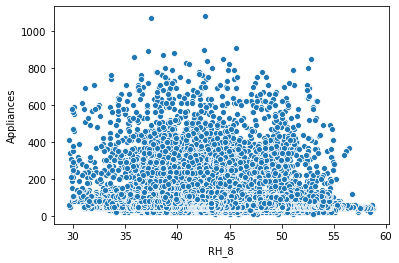

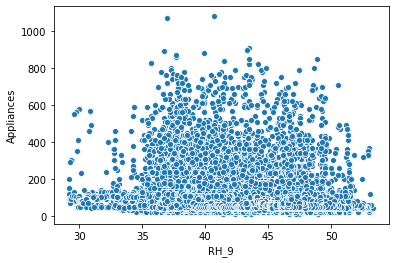

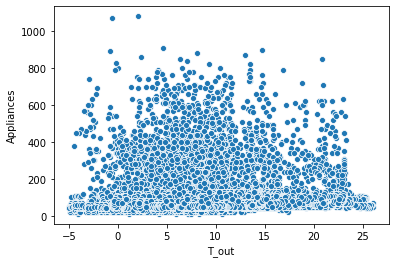

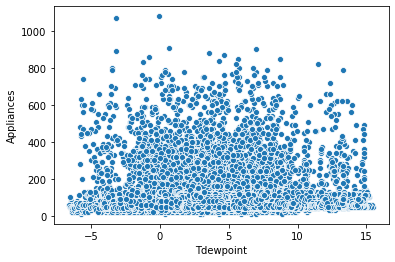

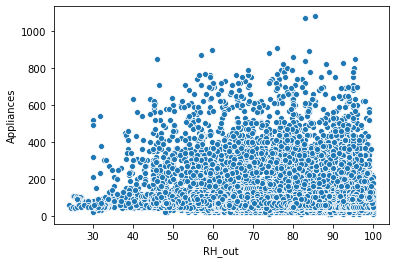

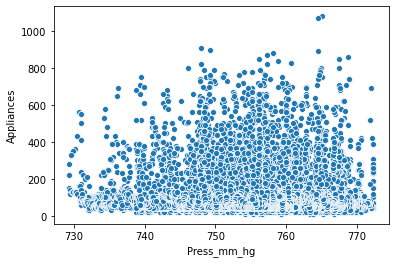

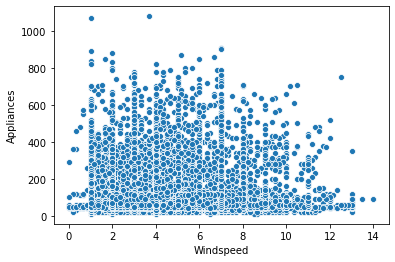

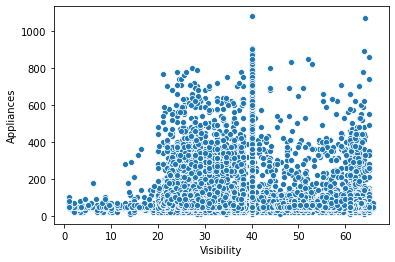

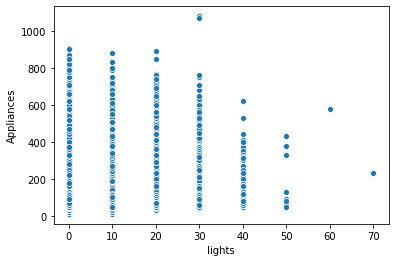

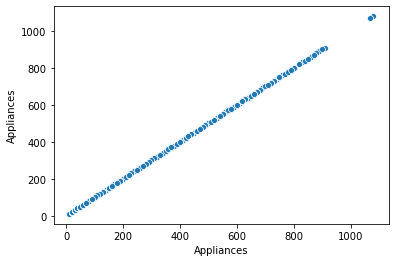

In [25]:
col=['day_of_week','week_day','hr_sec','T1','T2','T3','T4','T5','T6','T7','T8','T9','RH_1','RH_2','RH_3','RH_4','RH_5','RH_6','RH_7','RH_8','RH_9','T_out','Tdewpoint','RH_out','Press_mm_hg','Windspeed','Visibility']
for i, col in enumerate (dataset.columns):
    plt.figure(i)
    sns.scatterplot(x=dataset[col],y=dataset['Appliances'])

In [26]:
dataset.shape

(19735, 29)

#### Seperating independent and dependent variables

In [27]:
X = dataset[col_date + col_temp + col_hum + col_weather + col_light]
y = dataset[col_target]

In [28]:
X.shape

(19735, 28)

Data transformation to standardize the distribution

In [29]:
from sklearn.preprocessing import StandardScaler
x = dataset[col_hr_sec + col_temp + col_hum + col_weather + col_light]
scaled_features = StandardScaler().fit_transform(x.values)
x = pd.DataFrame(scaled_features, index=x.index, columns=x.columns)

In [30]:
days= dataset[['day_of_week','week_day']]

In [31]:
x.reset_index(drop=True, inplace=True)
days.reset_index(drop=True, inplace=True)

In [32]:
X = pd.concat([days, x], axis=1)

In [33]:
X.head(2)

day_of_week week_day    hr_sec        T1        T2        T3        T4  \
0         Mon  weekday  0.793301 -1.118645 -0.520411 -1.235063 -0.908217   
1         Mon  weekday  0.793702 -1.118645 -0.520411 -1.235063 -0.908217   

         T5        T6        T7  ...      RH_7      RH_8      RH_9     T_out  \
0 -1.314903 -0.145196 -1.453646  ...  1.219861  1.141572  0.958136 -0.152647   
1 -1.314903 -0.176941 -1.453646  ...  1.206825  1.134554  0.965363 -0.174588   

   Tdewpoint   RH_out  Press_mm_hg  Windspeed  Visibility    lights  
0   0.366975  0.82208    -2.976328   1.207694    2.091596  3.301264  
1   0.343135  0.82208    -2.962813   1.071703    1.766584  3.301264  

[2 rows x 28 columns]

In [34]:
from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(y.values)
y = pd.DataFrame(scaled_features, index=y.index, columns=y.columns)

#### Train Test Split of dataset

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=60)

##### Let's see the correlation between data

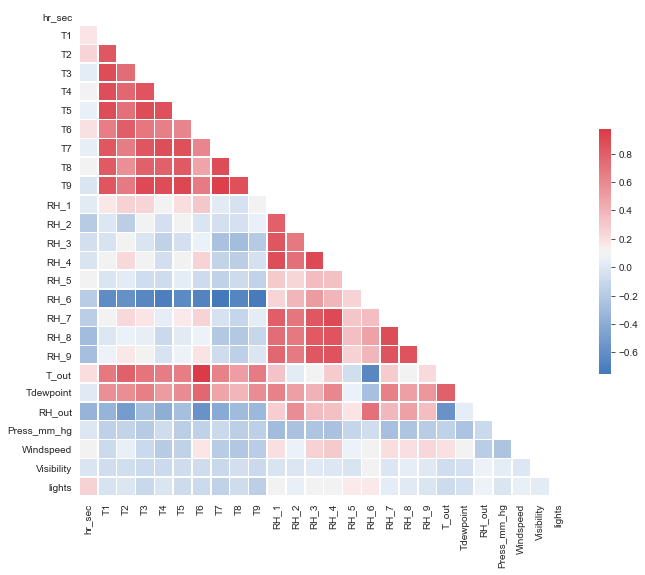

In [36]:
def CorrMtx(df, dropDuplicates = True):
    df = df.corr()
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    
    sns.set_style(style = 'white')

    
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(X_train, dropDuplicates = True)

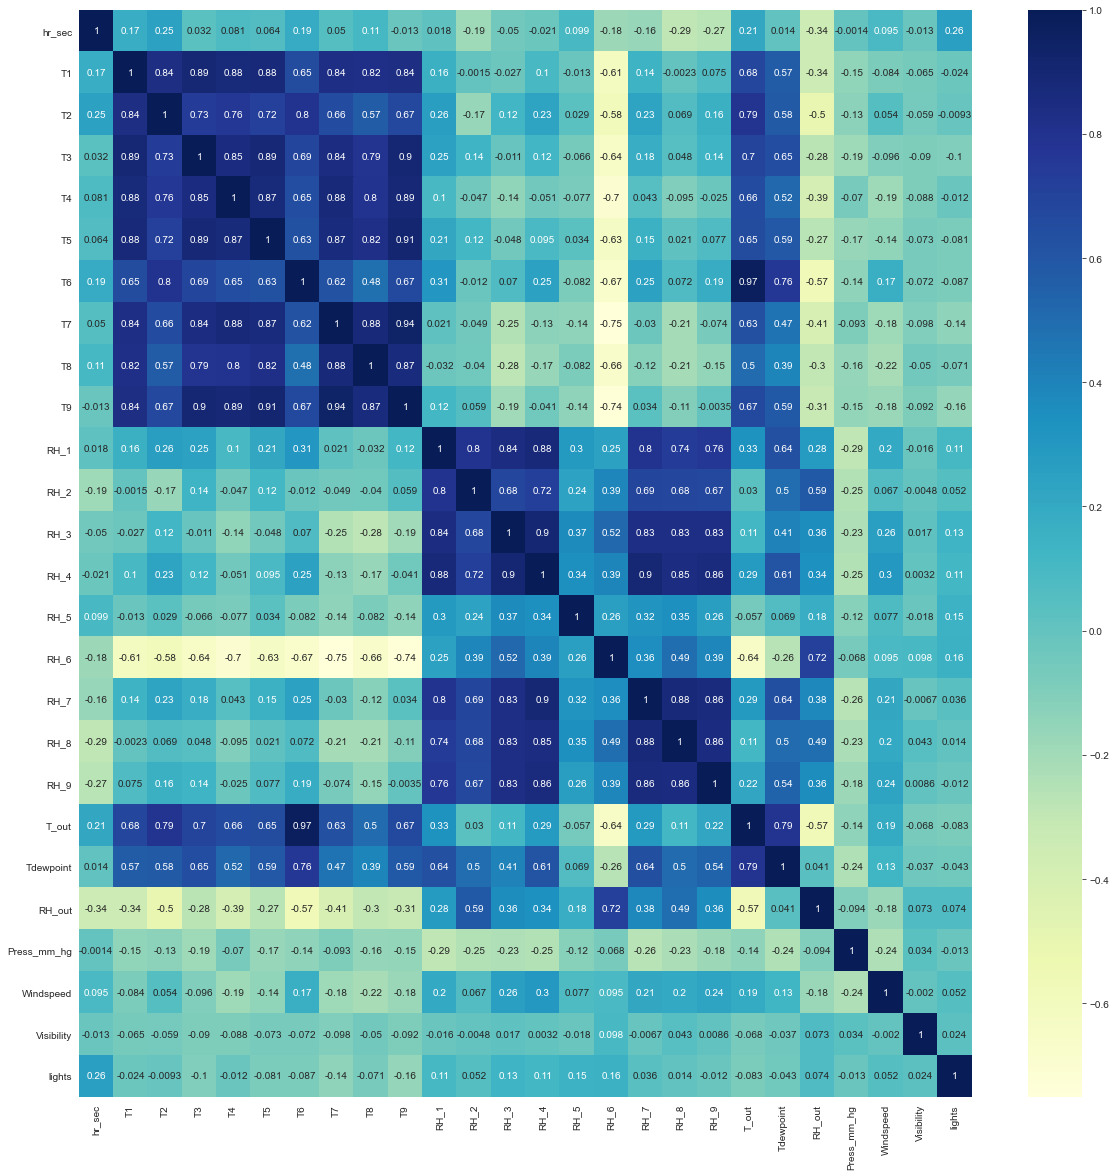

In [37]:
plt.figure(figsize = (20,20))
sns.heatmap(X_train.corr(), annot = True ,cmap = 'YlGnBu')
plt.show()

#### Let's find and remove correlated features

In [38]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

corr_features = correlation(X_train, 0.8)
print('Total number of correlated features: ', len(set(corr_features)) )

Total number of correlated features:  14


In [39]:
# removing correlated  features
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((13814, 14), (5921, 14))

In [40]:
X_train.head(2)

day_of_week week_day    hr_sec        T1      RH_1      RH_2      RH_5  \
18687         Fri  weekday -0.072324  0.794983  1.282569  1.281069 -0.280986   
12619         Fri  weekday -0.506541 -0.365232  0.303309  1.196542 -0.368287   

           RH_6  Tdewpoint    RH_out  Press_mm_hg  Windspeed  Visibility  \
18687 -0.408223   2.000050  0.587192     0.368605  -0.016218   -0.494372   
12619  0.214696   0.339161  1.235931    -0.129193  -1.240129    1.978549   

         lights  
18687  2.041149  
12619 -0.479080

#### One Hot Encoding of categorial variables (Day of week and Weekdays)

In [41]:
df_temp=X_train[['day_of_week','week_day']]

In [42]:
df_temp.shape

(13814, 2)

In [43]:
from sklearn.preprocessing import OneHotEncoder
encoder1=OneHotEncoder(sparse=False)
encoder2=OneHotEncoder(sparse=False)
df_temp_encoded_1 = pd.DataFrame (encoder1.fit_transform(df_temp[['day_of_week']]))
df_temp_encoded_2 = pd.DataFrame (encoder2.fit_transform(df_temp[['week_day']]))
df_temp_encoded_1.columns = encoder1.get_feature_names([''])
df_temp_encoded_2.columns = encoder2.get_feature_names([''])
print(df_temp_encoded_1.shape)
print(df_temp_encoded_2.shape)
print(df_temp_encoded_1.head(2))
print(df_temp_encoded_2.head(2))

(13814, 7)
(13814, 2)
   _Fri  _Mon  _Sat  _Sun  _Thu  _Tue  _Wed
0   1.0   0.0   0.0   0.0   0.0   0.0   0.0
1   1.0   0.0   0.0   0.0   0.0   0.0   0.0
   _weekday  _weekend
0       1.0       0.0
1       1.0       0.0


In [44]:
X_train.drop(['day_of_week', 'week_day'], axis = 1, inplace = True)

In [45]:
df_temp_encoded_1.reset_index(drop=True, inplace=True)
df_temp_encoded_2.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)

In [46]:
X_train_new = pd.concat([X_train, df_temp_encoded_1,df_temp_encoded_2 ], axis=1)

In [47]:
X_train_new.shape

(13814, 21)

In [48]:
X_train_new.head(2)

hr_sec        T1      RH_1      RH_2      RH_5      RH_6  Tdewpoint  \
0 -0.072324  0.794983  1.282569  1.281069 -0.280986 -0.408223   2.000050   
1 -0.506541 -0.365232  0.303309  1.196542 -0.368287  0.214696   0.339161   

     RH_out  Press_mm_hg  Windspeed  ...    lights  _Fri  _Mon  _Sat  _Sun  \
0  0.587192     0.368605  -0.016218  ...  2.041149   1.0   0.0   0.0   0.0   
1  1.235931    -0.129193  -1.240129  ... -0.479080   1.0   0.0   0.0   0.0   

   _Thu  _Tue  _Wed  _weekday  _weekend  
0   0.0   0.0   0.0       1.0       0.0  
1   0.0   0.0   0.0       1.0       0.0  

[2 rows x 21 columns]

In [49]:
df_temp=X_test[['day_of_week','week_day']]

In [50]:
from sklearn.preprocessing import OneHotEncoder
encoder1=OneHotEncoder(sparse=False)
encoder2=OneHotEncoder(sparse=False)
df_temp_encoded_1 = pd.DataFrame (encoder1.fit_transform(df_temp[['day_of_week']]))
df_temp_encoded_2 = pd.DataFrame (encoder2.fit_transform(df_temp[['week_day']]))
df_temp_encoded_1.columns = encoder1.get_feature_names([''])
df_temp_encoded_2.columns = encoder2.get_feature_names([''])
print(df_temp_encoded_1.shape)
print(df_temp_encoded_2.shape)
print(df_temp_encoded_1.head(2))
print(df_temp_encoded_2.head(2))

(5921, 7)
(5921, 2)
   _Fri  _Mon  _Sat  _Sun  _Thu  _Tue  _Wed
0   0.0   0.0   0.0   1.0   0.0   0.0   0.0
1   0.0   1.0   0.0   0.0   0.0   0.0   0.0
   _weekday  _weekend
0       0.0       1.0
1       1.0       0.0


In [51]:
X_test.drop(['day_of_week', 'week_day'], axis = 1, inplace = True)

In [52]:
df_temp_encoded_1.reset_index(drop=True, inplace=True)
df_temp_encoded_2.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [53]:
X_test_new = pd.concat([X_test, df_temp_encoded_1,df_temp_encoded_2 ], axis=1)

In [54]:
X_test_new.head(2)

hr_sec        T1      RH_1      RH_2      RH_5      RH_6  Tdewpoint  \
0  1.227920  0.460824  0.395455 -0.250735  3.382625  1.182250  -2.088597   
1  1.516461  0.942344 -0.517627 -0.014027 -0.504254  0.109717   0.120623   

     RH_out  Press_mm_hg  Windspeed  ...    lights  _Fri  _Mon  _Sat  _Sun  \
0 -0.218138     1.233557  -0.628173  ...  2.041149   0.0   0.0   0.0   1.0   
1  0.195712    -1.449147   0.935713  ... -0.479080   0.0   1.0   0.0   0.0   

   _Thu  _Tue  _Wed  _weekday  _weekend  
0   0.0   0.0   0.0       0.0       1.0  
1   0.0   0.0   0.0       1.0       0.0  

[2 rows x 21 columns]

In [55]:
np.any(np.isnan(X_train_new))

False

In [56]:
np.all(np.isnan(X_train_new))

False

In [57]:
np.any(np.isnan(y_train))

False

In [58]:
np.all(np.isnan(y_train))

False

In [59]:
X_train_new.reset_index(drop=True, inplace=True)

In [60]:
X_test_new.reset_index(drop=True, inplace=True)

In [61]:
y_train.reset_index(drop=True, inplace=True)

In [62]:
y_test.reset_index(drop=True, inplace=True)

In [63]:
X_train_new.shape

(13814, 21)

#### Model Building

In [64]:
from sklearn import preprocessing, model_selection, metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import neighbors

##### Let's check initial performance with different regression models

In [65]:
models = [['LinearRegression: ', LinearRegression()],['RandomForestRegression: ', RandomForestRegressor()],['SVR:' , SVR(kernel='rbf')],['KNeighborsRegressor: ',  neighbors.KNeighborsRegressor()],['ExtraTreeRegressor :',ExtraTreesRegressor()]]

In [66]:
import math
model_data = []
for name,curr_model in models :
    curr_model_data = {}
    curr_model.random_state = 1
    curr_model_data["Name"] = name
    curr_model.fit(X_train_new,y_train)
    curr_model_data["Train_R2_Score"] = metrics.r2_score(y_train,curr_model.predict(X_train_new))
    curr_model_data["Test_R2_Score"] = metrics.r2_score(y_test,curr_model.predict(X_test_new))
    curr_model_data["Test_RMSE_Score"] = math.sqrt(mean_squared_error(y_test,curr_model.predict(X_test_new)))
    model_data.append(curr_model_data)

In [67]:
pd.DataFrame(model_data)

Name  Train_R2_Score  Test_R2_Score  Test_RMSE_Score
0        LinearRegression:         0.122479       0.118352         0.912259
1  RandomForestRegression:         0.934981       0.547996         0.653193
2                      SVR:        0.257388       0.238003         0.848100
3     KNeighborsRegressor:         0.632332       0.423983         0.737374
4      ExtraTreeRegressor :        1.000000       0.568358         0.638311

##### ExtraTreeRegressor & RandomForestRegressor have better R2, as compared with other models
##### Let's explore this further, by selecting best features using Recursive Feature Elimination

#### Model building using RFE

In [68]:
from sklearn.feature_selection import RFE
#rfr = RandomForestRegressor()
#rfr.fit(X_train_new,y_train)
etr = ExtraTreesRegressor()
etr.fit(X_train_new,y_train)
# Subsetting training data for 11 selected columns
rfe = RFE(etr,11)
rfe.fit(X_train_new,y_train)

RFE(estimator=ExtraTreesRegressor(), n_features_to_select=11)

In [69]:
# Iterating by changing features count, we came to know what 11 features gives the best score
list(zip(X_train_new.columns,rfe.support_,rfe.ranking_))

[('hr_sec', True, 1),
 ('T1', True, 1),
 ('RH_1', True, 1),
 ('RH_2', True, 1),
 ('RH_5', True, 1),
 ('RH_6', True, 1),
 ('Tdewpoint', True, 1),
 ('RH_out', True, 1),
 ('Press_mm_hg', True, 1),
 ('Windspeed', True, 1),
 ('Visibility', True, 1),
 ('lights', False, 2),
 ('_Fri', False, 4),
 ('_Mon', False, 5),
 ('_Sat', False, 6),
 ('_Sun', False, 10),
 ('_Thu', False, 7),
 ('_Tue', False, 8),
 ('_Wed', False, 9),
 ('_weekday', False, 11),
 ('_weekend', False, 3)]

In [70]:
cols = X_train_new.columns[rfe.support_]
cols

Index(['hr_sec', 'T1', 'RH_1', 'RH_2', 'RH_5', 'RH_6', 'Tdewpoint', 'RH_out',
       'Press_mm_hg', 'Windspeed', 'Visibility'],
      dtype='object')

##### Keeping the relevant features only

In [71]:
X_train_1 = X_train_new[cols]

In [72]:
X_train_1.shape

(13814, 11)

In [73]:
X_test_1 = X_test_new[cols]

In [74]:
X_train_1.reset_index(drop=True, inplace=True)
X_test_1.reset_index(drop=True, inplace=True)

#### Checking the R2 after selecting relevant features only

In [75]:
# With Random Forest Regressor
rfr = RandomForestRegressor()
rfr.fit(X_train_1,y_train)
print("Model: Random Forest Regressor")
print("The Train_R2_Score after feature selection "+"{:.2f}".format(metrics.r2_score(y_train,rfr.predict(X_train_1))))
print("The Test_R2_Score after feature selection "+"{:.2f}".format(metrics.r2_score(y_test,rfr.predict(X_test_1))))
print("The Test_RMSE_Score after feature selection "+"{:.2f}".format(math.sqrt(mean_squared_error(y_test,rfr.predict(X_test_1)))))

Model: Random Forest Regressor
The Train_R2_Score after feature selection 0.94
The Test_R2_Score after feature selection 0.59
The Test_RMSE_Score after feature selection 0.62


In [76]:
# With Extra Tree Regressor
etr = ExtraTreesRegressor()
etr.fit(X_train_1,y_train)
print("Model: Extra Tree Regressor")
print("The Train_R2_Score after feature selection "+"{:.2f}".format(metrics.r2_score(y_train,etr.predict(X_train_1))))
print("The Test_R2_Score after feature selection "+"{:.2f}".format(metrics.r2_score(y_test,etr.predict(X_test_1))))
print("The Test_RMSE_Score after feature selection "+"{:.2f}".format(math.sqrt(mean_squared_error(y_test,etr.predict(X_test_1)))))

Model: Extra Tree Regressor
The Train_R2_Score after feature selection 1.00
The Test_R2_Score after feature selection 0.61
The Test_RMSE_Score after feature selection 0.60


#### We can clearly see that R2 score have been improved after reducing the features
##### The R2 score improved as:
##### Random Forest Regressor:  0.55 to 0.59 (Test Data)
##### Extra Tree Regressor: 0.57 to 0.62 (Test Data)

#### Also the fetures have been reduced from 21 to 11

### let's use Grid Search CV to further tune the Hyperparameters of Extra Tree Regressor Model

In [77]:
from sklearn.model_selection import GridSearchCV
gsc = GridSearchCV(estimator=ExtraTreesRegressor(),param_grid={'max_depth': (70,80),'n_estimators': (100,200,300), 'max_features':("auto","sqrt")},
cv=5, scoring='r2', verbose=0, n_jobs=-1)
grid_result = gsc.fit(X_train_1,y_train)
etr_1 = grid_result.best_estimator_  
etr_1.fit(X_train_1,y_train)
#rfr_pred=rfc.predict(X_test_1)
print("The best parameters are: ",grid_result.best_estimator_ )
print("The Train_R2_Score: "+"{:.2f}".format(metrics.r2_score(y_train,etr_1.predict(X_train_1))))
print("The Test_R2_Score: "+"{:.2f}".format(metrics.r2_score(y_test,etr_1.predict(X_test_1))))
print("The Test_RMSE_Score "+"{:.2f}".format(math.sqrt(mean_squared_error(y_test,etr_1.predict(X_test_1)))))

The best parameters are:  ExtraTreesRegressor(max_depth=70, max_features='sqrt', n_estimators=300)
The Train_R2_Score: 1.00
The Test_R2_Score: 0.64
The Test_RMSE_Score 0.58


##### The R2 is further improved to 0.64 (Test Data) 

### Conclusion:
#### The best algorithm for the dataset is Extra Tree Regressor.
#### The engineered feature seconds at every hour is one of the most relevent feature to predict the energy consumption.
#### The untuned model was able to explain 57% variance on test data.
#### After tuning,  the model was able to explain 63% variance on test data (approx. 11% improved).
#### The initial dataset was having 28 features, which is reduced to 11 features.
#### Further reduction in variables is not improving score of model.
#### High R2 in train data set have to explored further

##### However the project is not completed yet, as we can explore more model on this data.